In [1]:
from helper import (load_data, token, DanishCleaner,time_me,
                    show_diagram, show_most_informative_features)

In [2]:
## Long process timing that %time does not work
from datetime import datetime
import humanfriendly


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [4]:
from sklearn.externals import joblib
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)

#### TfidfVectorizer == CountVectorizer + TfidfTransformer

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LogisticRegression

In [65]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 4 seconds


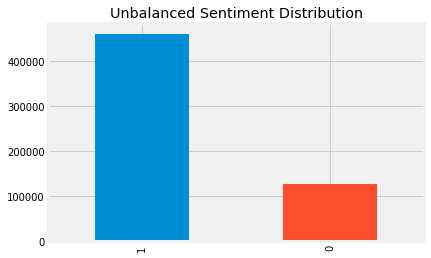

In [7]:
df = load_data('../sentiment_data', balanced=True)

In [8]:
df = df.sample(5000)

In [9]:
 X_train, X_test, y_train, y_test = train_test_split(df['features'], df['y'],
                                                    test_size=.2, random_state=7,stratify=df['y'])

In [10]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')

Traing Size: 4000
Test Size:     1000


In [11]:
print(f'Traing Size\n\tPositive||Negative Sample\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')

Traing Size
	Positive||Negative Sample
	  1976||2024


In [12]:
print(f'Test Size\n\tPositive||Negative Sample\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Test Size
	Positive||Negative Sample
	  494||506


In [66]:
count_para = dict(ngram_range=(2, 3),tokenizer=token,
                     lowercase=True,stop_words=stops,min_df=10)
tfidf_para = dict(ngram_range=(2, 3), lowercase=True,max_df=.8,
                  min_df=10, sublinear_tf=True,stop_words=stops)

lda_para = dict(n_components=2, max_iter=50, learning_method='online', verbose=1,
                learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,random_state=7)

logit_para = dict(C=1., penalty='l2',max_iter=500,random_state=7,warm_start=True, 
                  verbose=1, solver='saga', n_jobs=4)  #n_jobs=-1 does not have any effect when solver is liblinear l2



In [57]:
model = Pipeline ([
    ('text_union', FeatureUnion([
                        ('lda_pipe', Pipeline([
                            ('countvec', CountVectorizer(**count_para)),
                            ('fe_se', SelectKBest(chi2, k=50)),
                            ('lda',LatentDirichletAllocation(**lda_para))
                                            ])),
                        ('tfidf_pipe', Pipeline([
                                            ('tfidf', TfidfVectorizer(**tfidf_para)),
                                            ('fe_se', SelectKBest(chi2, k=50))
                                                            ])),
                                        
                                                ])
                    ),
    ('clf', LogisticRegression(**logit_para))
    
])

In [67]:
u = datetime.now()
model.fit(X_train, y_train)
v = datetime.now()

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished


In [68]:
delta = v-u
print('Training took: {}'.format(
            humanfriendly.format_timespan(delta.seconds)))

Training took: 14 seconds


Classification Report
	 _____________________________________________
             precision    recall  f1-score   support

   Negative       0.92      0.85      0.89       506
   Positive       0.86      0.93      0.89       494

avg / total       0.89      0.89      0.89      1000

	 _____________________________________________ 




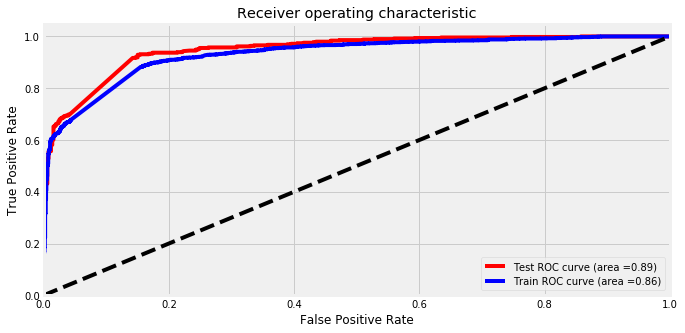

Execution Time: 9 seconds


In [69]:
show_diagram(model,X_train, y_train, X_test, y_test,compare_test=True)

In [70]:
vec_features = model.steps[0][1].transformer_list[0][1].steps[0][1].get_feature_names()
best_vec_features = [vec_features[i] for i in  model.steps[0][1].transformer_list[0][1].steps[1][1].get_support(indices=True)]

In [71]:
tf_features  = model.steps[0][1].transformer_list[1][1].steps[0][1].get_feature_names()
best_tf_features = [tf_features[i] for i in  model.steps[0][1].transformer_list[1][1].steps[1][1].get_support(indices=True)] # step 1 == fe_se

In [72]:
show_most_informative_features(best_vec_features, model.steps[1][1], n=50)

	-6.4740	ikk mul        		5.8627	ikk først      
	-4.2032	find pak       		4.3825	hurt god       
	-3.7653	hjem hel       		4.2603	ikk hjem       
	-3.4897	ikk pak        		3.7619	lev pak        
	-2.9567	lang tid       		3.5201	send pak       
	-2.7966	desvær ikk     		3.4819	sup hurt       
	-2.7268	stad ikk       		3.2877	ing problem    
	-2.6590	ikk vær        		3.2197	modtag pak     
	-2.4195	forsøg aflev   		3.1445	endnu ikk      
	-2.3798	pak ikk        		2.5737	forsøg lev     
	-2.2781	åbenbart ikk   		2.3738	slet ikk       
	-2.2768	ikk modtag     		2.1551	godt nok       
	-2.2732	pak skul       		1.8900	hent pak       
	-2.1702	pak posthus    		1.6166	ell and        
	-2.1504	dår servic     		1.3073	ing pak        
	-2.1486	havd vær       		1.0275	pak bliv       
	-2.1006	bliv lev       		0.9179	and sted       
	-2.0732	eft hav        		0.9153	ikk ord        
	-2.0167	rigt god       		0.3986	ikk lev        
	-1.8541	meg tilfred    		0.3140	skul hav       
	-1.7459	bar ikk    

In [73]:
show_most_informative_features(best_tf_features, model.steps[1][1], n=50)

	-6.4740	ingen problemer		5.8627	hurtigt        
	-4.2032	fin            		4.3825	hele dagen     
	-3.7653	god hurtig     		4.2603	igen           
	-3.4897	nem            		3.7619	problemer      
	-2.9567	posthuset      		3.5201	tiden          
	-2.7966	betalt         		3.4819	vide           
	-2.7268	uge            		3.2877	perfekt        
	-2.6590	nemt           		3.2197	siden          
	-2.4195	finde          		3.1445	dårligt        
	-2.3798	stod           		2.5737	fint           
	-2.2781	væk            		2.3738	tilfreds       
	-2.2768	ikke modtaget  		2.1551	forsøgt        
	-2.2732	super          		1.8900	god            
	-2.1702	står           		1.6166	dårlig         
	-2.1504	betjening      		1.3073	nok            
	-2.1486	fungerede      		1.0275	stedet         
	-2.1006	betale         		0.9179	adresse        
	-2.0732	dejligt        		0.9153	måtte          
	-2.0167	super hurtig   		0.3986	ikke           
	-1.8541	rigtig god     		0.3140	tilbage        
	-1.7459	aldrig     